In [5]:
import deepchem as dc
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from deepchem.models import GraphConvModel
from deepchem.models.callbacks import ValidationCallback

# Load the dataset
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

# Define the model
model = GraphConvModel(n_tasks=len(tasks), mode='classification', dropout=0.2)

# Define early stopping parameters
patience = 10
interval = 1
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")

def fit_with_early_stopping(model, train_dataset, valid_dataset, nb_epoch, patience):
    best_score = None
    best_epoch = None
    best_model = None
    list_scores = []
    wait = 0

    for epoch in range(nb_epoch):
        print(f"Epoch {epoch+1}/{nb_epoch}")
        model.fit(train_dataset, nb_epoch=1)

        if (epoch + 1) % interval == 0:
            valid_scores = model.evaluate(valid_dataset, [metric], transformers)
            valid_score = valid_scores[metric.name]
            print(valid_scores)

            training_scores = model.evaluate(train_dataset, [metric], transformers)
            training_score = training_scores[metric.name]

            list_scores.append((epoch + 1, valid_score, training_score))

            if best_score is None or valid_score > best_score:
                best_score = valid_score
                best_epoch = epoch + 1
                best_model = model.save_checkpoint(model_dir="model.ckpt")
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered at epoch:", epoch + 1)
                    break
    
    print(f"Best model found at epoch {best_epoch} with {metric.name} score: {best_score}")
    return list_scores

# Train the model with early stopping
my_model = fit_with_early_stopping(model, train_dataset, valid_dataset, nb_epoch=100, patience=patience)


Epoch 1/100
{'mean-roc_auc_score': 0.6216694432682178}
Epoch 2/100
{'mean-roc_auc_score': 0.6750504590843391}
Epoch 3/100
{'mean-roc_auc_score': 0.6758609812293814}
Epoch 4/100
{'mean-roc_auc_score': 0.6955412870269088}
Epoch 5/100
{'mean-roc_auc_score': 0.7066479496022565}
Epoch 6/100
{'mean-roc_auc_score': 0.7093792717460884}
Epoch 7/100
{'mean-roc_auc_score': 0.7066403603312836}
Epoch 8/100
{'mean-roc_auc_score': 0.7229276358300033}
Epoch 9/100
{'mean-roc_auc_score': 0.7236156136146187}
Epoch 10/100
{'mean-roc_auc_score': 0.7204347650534841}
Epoch 11/100
{'mean-roc_auc_score': 0.7235485706268574}
Epoch 12/100
{'mean-roc_auc_score': 0.7171393272518894}
Epoch 13/100
{'mean-roc_auc_score': 0.7329452197436442}
Epoch 14/100
{'mean-roc_auc_score': 0.7096648534877551}
Epoch 15/100
{'mean-roc_auc_score': 0.7293442331425677}
Epoch 16/100
{'mean-roc_auc_score': 0.7354745352320416}
Epoch 17/100
{'mean-roc_auc_score': 0.7384127574317172}
Epoch 18/100
{'mean-roc_auc_score': 0.7343191932157835}
E

<function matplotlib.pyplot.show(close=None, block=None)>

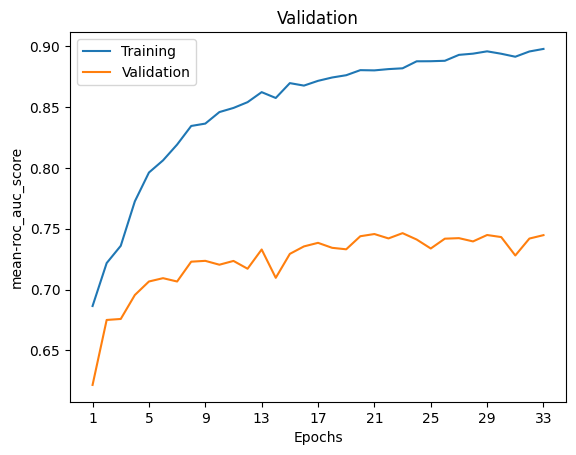

In [6]:
epochs = [x[0] for x in my_model]
train_scores = [x[2] for x in my_model]
valid_scores = [x[1] for x in my_model]

plt.plot(epochs, train_scores, label='Training')
plt.plot(epochs, valid_scores, label='Validation')
plt.gca().set(xlabel='Epochs', ylabel=metric.name, title='Validation')
plt.xticks(range(min(epochs), max(epochs) + 1, 4))
plt.legend()
plt.show

In [7]:
load_model = GraphConvModel(n_tasks=len(tasks), mode='classification', dropout=0.2)

# Disables warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# restores model
status = load_model.restore(model_dir="model.ckpt")

# Reenables warnings
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

In [8]:
eval = load_model.evaluate(valid_dataset, [metric], transformers)
print(eval)

preds = load_model.predict(test_dataset)
preds

{'mean-roc_auc_score': 0.7463682090634561}


array([[[0.2284384 , 0.77156156],
        [0.46285897, 0.537141  ],
        [0.86148024, 0.13851976],
        ...,
        [0.8711109 , 0.12888914],
        [0.8914134 , 0.1085867 ],
        [0.8524285 , 0.14757156]],

       [[0.4779825 , 0.5220175 ],
        [0.38543802, 0.614562  ],
        [0.29307795, 0.70692205],
        ...,
        [0.1086456 , 0.89135444],
        [0.05872167, 0.9412783 ],
        [0.0185052 , 0.9814948 ]],

       [[0.6223571 , 0.37764293],
        [0.716755  , 0.28324506],
        [0.20984447, 0.79015553],
        ...,
        [0.1993955 , 0.80060446],
        [0.00852628, 0.9914737 ],
        [0.20095262, 0.7990474 ]],

       ...,

       [[0.8583247 , 0.14167528],
        [0.8334689 , 0.16653103],
        [0.11350249, 0.88649756],
        ...,
        [0.50134116, 0.49865878],
        [0.29097497, 0.70902497],
        [0.28819948, 0.7118005 ]],

       [[0.93651915, 0.06348088],
        [0.45367593, 0.5463241 ],
        [0.90832585, 0.09167412],
        .